In [ ]:
import tensorflow.keras as K
import tensorflow as tf

In [ ]:
def preprocess_data(X, Y):
    """
    Pre-processes the data for the model

        :param X: numpy.ndarray of shape (m, 32, 32, 3)
            containing the CIFAR 10 data, where m is the
            number of data points

        :param Y: numpy.ndarray of shape (m,) containing
            the CIFAR 10 labels for X

        :returns: X_p, Y_p
    """
    X_p = K.applications.mobilenet_v3.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar10.h5'
optimizer = K.optimizers.Adam()

# load cifar 10
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()

# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

# input tensor
inputs = K.Input(shape=(32, 32, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
                                                                  160,
                                                                  160,
                                                                  method=tf.image.ResizeMethod.BILINEAR))(inputs)

# load base model
base_model = K.applications.MobileNetV3Small(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(160,160,3),
                                        pooling='max')



# add top layers
out = base_model.output
out = K.layers.Flatten()(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(256, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(128, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(64, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.Dense(10, activation='softmax')(out)

# callbacks
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))

# model compile
model = K.models.Model(inputs=inputs, outputs=out)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# train
history= model.fit(x=x_train,
          y=y_train,
          batch_size=128,
          epochs=20,
          callbacks=CALLBACKS,
          validation_data=(x_test, y_test))

4349952/4334752 [==============================] - 0s 0us/step
Epoch 1/20
391/391 [==============================] - 1259s 3s/step - loss: 0.6508 - accuracy: 0.7978 - val_loss: 0.6281 - val_accuracy: 0.8248
Epoch 2/20
391/391 [==============================] - 1306s 3s/step - loss: 0.2866 - accuracy: 0.9144 - val_loss: 1.0596 - val_accuracy: 0.7294
Epoch 3/20
391/391 [==============================] - 1303s 3s/step - loss: 0.2074 - accuracy: 0.9375 - val_loss: 1.1211 - val_accuracy: 0.7143
Epoch 4/20
391/391 [==============================] - 1297s 3s/step - loss: 0.1645 - accuracy: 0.9506 - val_loss: 0.6618 - val_accuracy: 0.8213
Epoch 5/20
391/391 [==============================] - 1273s 3s/step - loss: 0.1391 - accuracy: 0.9582 - val_loss: 0.7144 - val_accuracy: 0.8228
Epoch 6/20
391/391 [==============================] - 1317s 3s/step - loss: 0.1164 - accuracy: 0.9655 - val_loss: 0.8937 - val_accuracy: 0.7895
Epoch 7/20
391/391 [==============================] - 1324s 3s/step - los

In [ ]:
import numpy as np
def plot_confusion_matrix(cm, classes, normalize, title):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    title_font = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 15}
    label_font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 10}
    plt.title(title, fontdict=title_font)
    plt.ylabel('True label',fontdict=label_font)
    plt.xlabel('Predicted label',fontdict=label_font)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

In [ ]:
from sklearn.metrics import confusion_matrix  
#### To analyze results, plot the confusion matrix using the following command
#Predict the test results
predict_x=model.predict(x_test) 
y_predict=np.argmax(predict_x,axis=1)
y_test_labels = y_test.argmax(1)
#confusion matrix and classification report
print("Confusion Matrix\n",confusion_matrix(y_test_labels,y_predict))

Confusion Matrix
 [[948   4  19   6   3   0   0   5  14   1]
 [ 14 971   1   0   0   0   2   0   3   9]
 [ 26   1 909  15   7  13  11  14   4   0]
 [ 19   1  32 858   6  54   2  16   9   3]
 [ 11   0  37  41 829  28   4  46   4   0]
 [ 14   2  12 112   7 829   4  18   2   0]
 [ 15   3  24  44   5  13 871   8  17   0]
 [  8   0   6   9   2  18   0 956   1   0]
 [ 49   5   3   1   0   1   0   4 935   2]
 [ 43  59   2   6   0   0   0   8  16 866]]


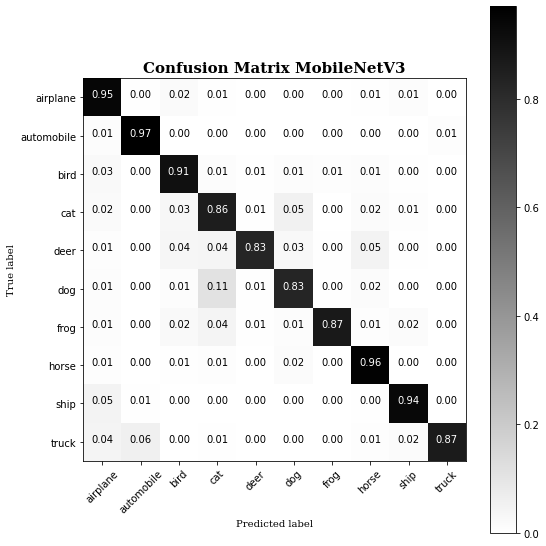

In [ ]:
# Compute confusion matrix
import matplotlib.pyplot as plt
import itertools   
cnf_matrix = confusion_matrix(y_test_labels,y_predict)
np.set_printoptions(precision=2)
label_names = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]
# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=label_names, normalize=True, 
                      title='Confusion Matrix MobileNetV3')

In [ ]:
model.evaluate(x_test, y_test, batch_size=128, verbose=1)

79/79 [==============================] - 3s 33ms/step - loss: 0.4851 - accuracy: 0.8972


[0.4851282238960266, 0.8971999883651733]